# Unsupervised learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Principal Component Analysis

Problem:
- many variables/features means many **dimensions**
- As dimensions increase, more data is needed to fill the "empty spaces"
- We don't have this much data

Consider 2 features ($x_1, x_2$) en $x_2 = 3x_1$

Why is this problematic? 

Solution: reduce dimensionality of the data with, e.g., PCA
- Unsupervised (we do not use outputs/labels/y-values)
- PCA projects $d$-dimensional data to a $(k < d)$-dimensional space such that the variance after projection is maximized.
- **Con**: new features are not interpretable
- **Pro**: new features convey almost the same amount of information as old features  
- https://setosa.io/ev/principal-component-analysis/

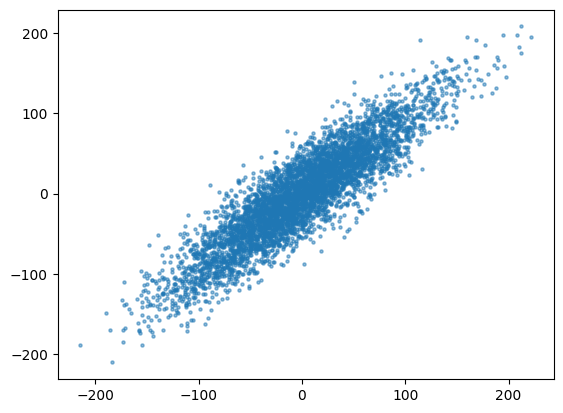

In [15]:
d = 2 # dimensionality of data

# multivariate normal parameters
mean = [0, 0]
cov = [
    [1, 0.9], 
    [0.9, 1]
]
# sample from multivariate normal
x = np.random.multivariate_normal(mean=mean, cov=cov, size=(5000,)) * 60

plt.scatter(x[:, 0], x[:, 1], s=5, alpha=0.5)

In [16]:
# standardize such that x in N(0, 1)
x = (x - x.mean(keepdims=True)) / x.std(keepdims=True)

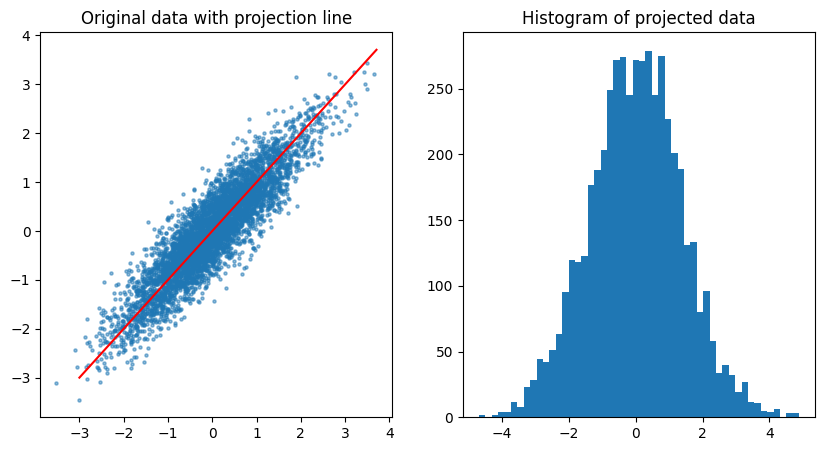

In [17]:
from sklearn.decomposition import PCA

# apply PCA with 1 component
pca = PCA(n_components=1).fit(x)
x_proj = pca.transform(x)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(x[:, 0], x[:, 1], s=5, alpha=0.5)

# plot original data + PCA projection line
mean = x.mean()
pc1x = pca.components_[0, 0] + mean
pc1y = pca.components_[0, 1] + mean
ax1.plot([mean-3, pc1x+3], [mean-3, pc1y+3], c='r')
ax1.set_title(f"Original data with projection line")

# histogram of projected data
ax2.hist(x_proj, bins=50)
ax2.set_title(f"Histogram of projected data")
plt.show()

In [18]:
x.shape, x_proj.shape

((5000, 2), (5000, 1))

## PCA analysis

How many principal components do we need? 

In [19]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True)

X.shape, y.shape

((442, 10), (442,))

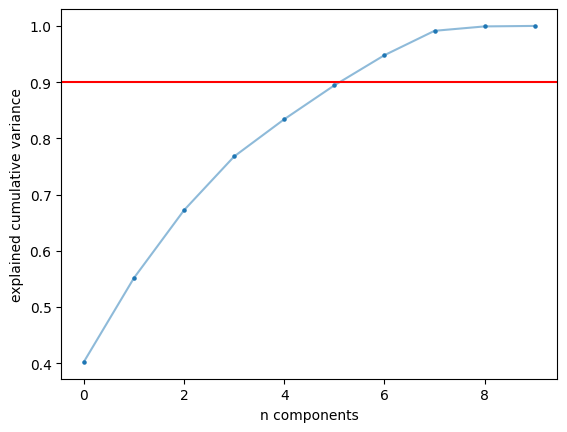

In [20]:
pca = PCA(n_components=X.shape[1]).fit(X)
X_proj = pca.transform(X)

cumulative_expl_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(pca.explained_variance_)), cumulative_expl_var, alpha=0.5)
plt.scatter(range(len(pca.explained_variance_)), cumulative_expl_var, s=5)
plt.xlabel("n components")
plt.ylabel("explained cumulative variance")
plt.axhline(0.9, color='red')

In [21]:
cumulative_expl_var

array([0.40242108, 0.55165304, 0.67224967, 0.76779731, 0.83401545,
       0.89428716, 0.94794372, 0.99131192, 0.99914393, 1.        ])

In [22]:
pca = PCA(n_components=.9, svd_solver='full').fit(X)
pca_X = pca.transform(X)

pca_X.shape

(442, 7)

## Clustering the class

In [36]:
class_ratings = pd.DataFrame([
    [1, 2, 5, 1, 'A'],
    [4, 2, 3, 3, 'B'],
    [5, 1, 4, 3, 'C'],
    [3, 1, 4, 2, 'D'],
    [2, 5, 5, 1, 'E'],
    [2, 5, 5, 2, 'F'],
    [3, 1, 1, 1, 'G'],
], columns=['Music', 'Sports', 'Technology', 'Fashion', 'Name'])

In [37]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=4).fit_predict(class_ratings.iloc[:, :-1])
clusters

array([1, 3, 3, 1, 0, 0, 2], dtype=int32)

In [38]:
class_ratings['Cluster'] = clusters

class_ratings

Music  Sports  Technology  Fashion Name  Cluster
0      1       2           5        1    A        1
1      4       2           3        3    B        3
2      5       1           4        3    C        3
3      3       1           4        2    D        1
4      2       5           5        1    E        0
5      2       5           5        2    F        0
6      3       1           1        1    G        2

## K-means clustering

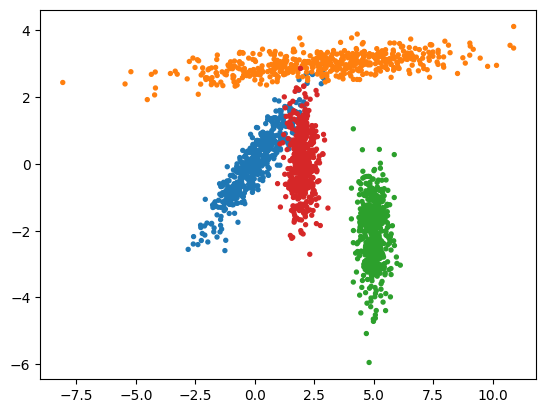

In [12]:
from matplotlib.colors import ListedColormap

cmap1 = ListedColormap(['C0', 'C1', 'C2', 'C3'])

df = pd.read_csv("../datasets/data_dc4_p1.csv")

y = df['y']
X = df.drop(columns='y').to_numpy()

# maak meshgrid om beslisgrenzen te laten zien
xmin = X[:, 0].min(); xmax = X[:, 0].max()
ymin = X[:, 1].min(); ymax = X[:, 1].max()
xx, yy = np.meshgrid(
    np.linspace(xmin-.5, xmax+.5, 100),
    np.linspace(ymin-.5, ymax+.5, 100)
)
D = np.vstack((xx.flatten(), yy.flatten())).T

plt.scatter(X[:, 0], X[:, 1], s=8, c=y, cmap=cmap1)
plt.show()

In [141]:
k_clusters = 4

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

# initial mean vectors 
m = np.array([
    X_mean + np.random.normal(0, X_std, size=2) for k in range(k_clusters)
])

X_mean, X_std, m

(array([2.47385127, 0.2514462 ]),
 array([2.39310884, 1.98486962]),
 array([[ 0.87327865, -1.88686643],
        [ 0.9383852 ,  1.38753208],
        [ 1.79281496, -0.6415221 ],
        [ 0.42658787, -0.40697128]]))

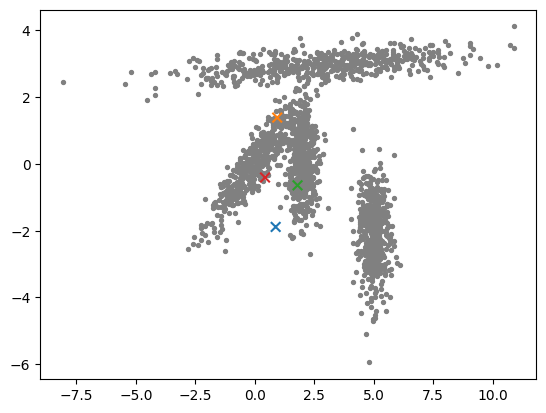

In [142]:
plt.scatter(X[:, 0], X[:, 1], s=8, c='gray')
plt.scatter(m[:, 0], m[:, 1], c=cmap1.colors, s=48, marker='x')
plt.show()

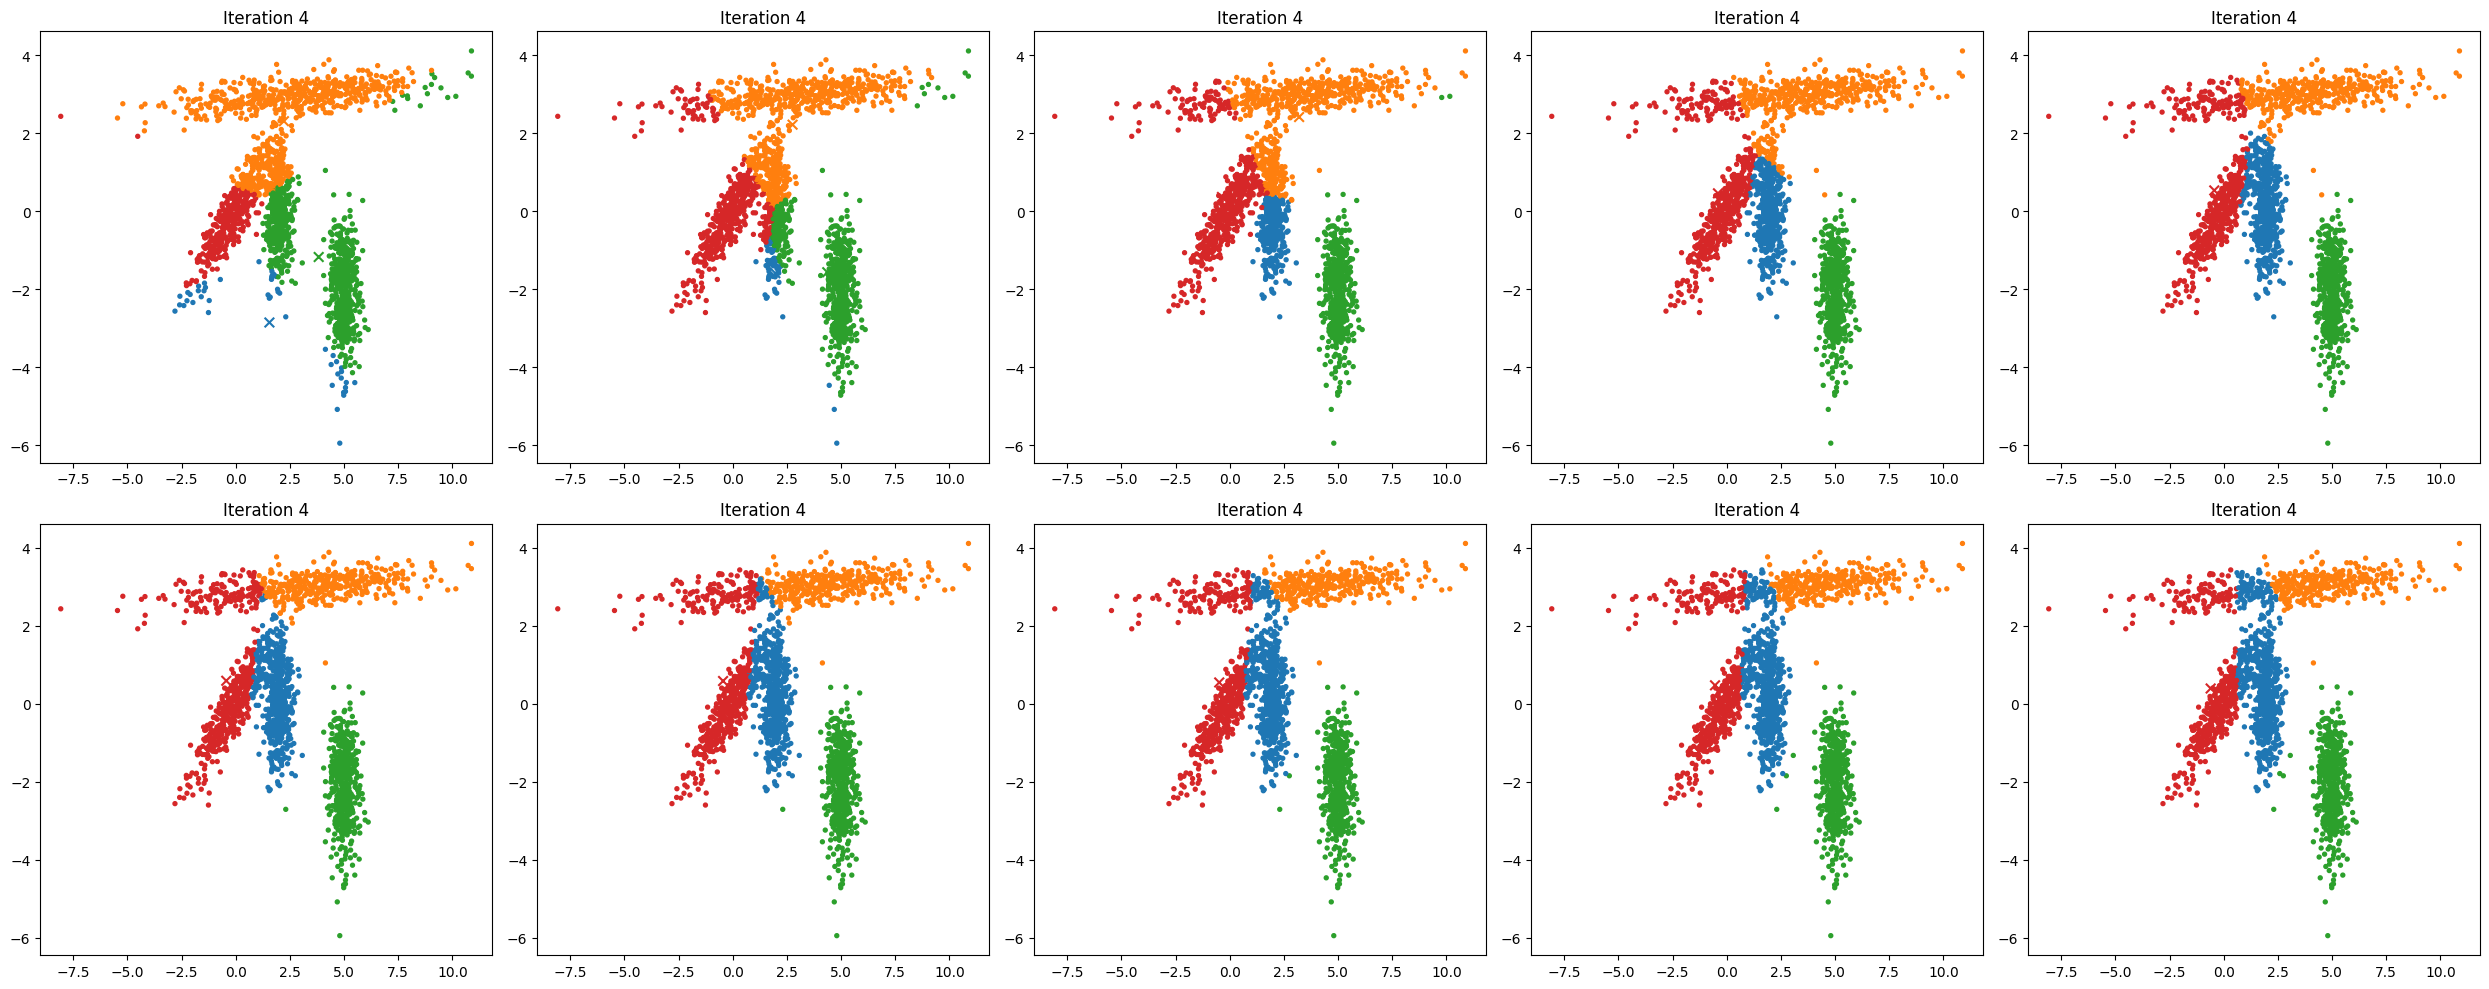

In [143]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

for i, ax in enumerate(axes): # 10 epochs

    # initialise labels (zero matrix with N rows and n_means columns)
    b = np.zeros((X.shape[0], m.shape[0]))

    for t, xt in enumerate(X):
        # compute euclidean distances from each xt to mi 
        dist = [np.linalg.norm(xt - mi) for mi in m]
        # take argmin i
        i = min(range(len(dist)), key=lambda x: dist[x])
        # update estimated labels
        b[t, i] = 1
            
    for i, mi in enumerate(m):
        # compute new estimates for means
        m[i] = np.sum((b[:, i, None] * X), axis=0) / np.sum(b[:, i])

    ax.set_title(f'Iteration {i+1}')
    ax.scatter(X[:, 0], X[:, 1], s=8, c=b.argmax(axis=1), cmap=cmap1)
    ax.scatter(m[:, 0], m[:, 1], s=48, c=cmap1.colors, marker='x')
    
plt.tight_layout()
plt.show()

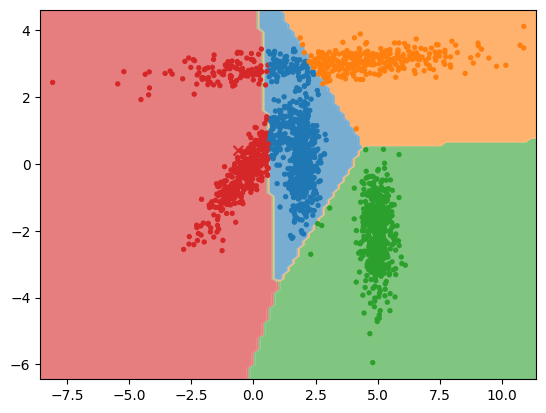

In [176]:
distances = np.linalg.norm(D[..., None, :] - m, axis=2)
min_dist = np.argmin(distances, axis=1)
y_pred = np.eye(k_clusters)[min_dist]

plt.contourf(xx, yy, y_pred.argmax(axis=1).reshape(xx.shape), cmap=cmap1, alpha=0.6, antialiased=True)
plt.scatter(X[:, 0], X[:, 1], s=8, c=b.argmax(axis=1), cmap=cmap1)
plt.scatter(m[:, 0], m[:, 1], s=48, c=cmap1.colors, marker='x')

### Sklearn K-means implementation

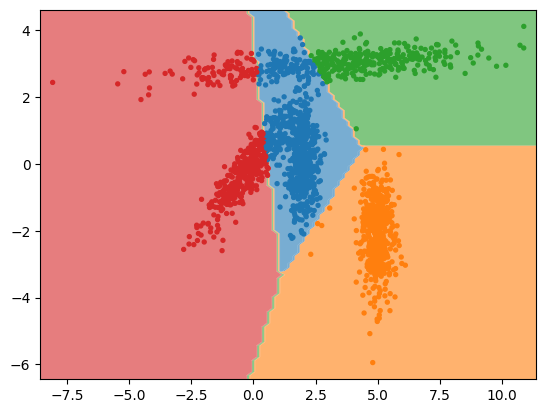

In [182]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k_clusters).fit(X)

y_pred = kmeans.predict(D)
b_kmeans = kmeans.predict(X)

plt.contourf(xx, yy, y_pred.reshape(xx.shape), cmap=cmap1, alpha=0.6, antialiased=True)
plt.scatter(X[:, 0], X[:, 1], s=8, c=b_kmeans, cmap=cmap1)

### Sklearn Gaussian Mixture Model 

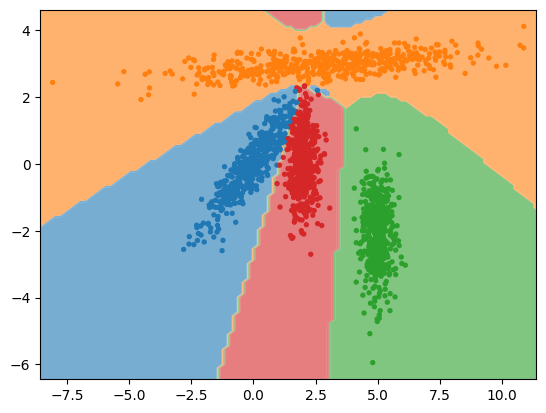

In [183]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=k_clusters).fit(X)

y_pred = gmm.predict(D)
b_gmm = gmm.predict(X)

plt.contourf(xx, yy, y_pred.reshape(xx.shape), cmap=cmap1, alpha=0.6, antialiased=True)
plt.scatter(X[:, 0], X[:, 1], s=8, c=b_gmm, cmap=cmap1)

## Exercise 1

In [16]:
df = pd.read_csv("../datasets/data_dc5.csv")

df

Alcohol  Malic_Acid   Ash  Ash_Alcanity  Magnesium  Total_Phenols  \
0      14.23        1.71  2.43          15.6        127           2.80   
1      13.20        1.78  2.14          11.2        100           2.65   
2      13.16        2.36  2.67          18.6        101           2.80   
3      14.37        1.95  2.50          16.8        113           3.85   
4      13.24        2.59  2.87          21.0        118           2.80   
..       ...         ...   ...           ...        ...            ...   
173    13.71        5.65  2.45          20.5         95           1.68   
174    13.40        3.91  2.48          23.0        102           1.80   
175    13.27        4.28  2.26          20.0        120           1.59   
176    13.17        2.59  2.37          20.0        120           1.65   
177    14.13        4.10  2.74          24.5         96           2.05   

     Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  Color_Intensity   Hue  \
0          3.06                  0.28             2.29             5.64  1.04   
1          2.76                  0.26             1.28             4.38  1.05   
2          3.24                  0.30             2.81             5.68  1.03   
3          3.49                  0.24             2.18             7.80  0.86   
4          2.69                  0.39             1.82             4.32  1.04   
..          ...                   ...              ...              ...   ...   
173        0.61                  0.52             1.06             7.70  0.64   
174        0.75                  0.43             1.41             7.30  0.70   
175        0.69                  0.43             1.35            10.20  0.59   
176        0.68                  0.53             1.46             9.30  0.60   
177        0.76                  0.56             1.35             9.20  0.61   

     OD280  Proline  
0     3.92     1065  
1     3.40     1050  
2     3.17     1185  
3     3.45     1480  
4     2.93      735  
..     ...      ...  
173   1.74      740  
174   1.56      750  
175   1.56      835  
176   1.62      840  
177   1.60      560  

[178 rows x 13 columns]

In [3]:
from sklearn.cluster import KMeans

n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters).fit(df)

b_kmeans = kmeans.predict(df)

b_kmeans

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

### Cluster analysis

In [4]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

total_wcss_values = []

for n in n_clusters:

    kmeans = KMeans(n_clusters=n).fit(df)
    b_kmeans = kmeans.predict(df)

    total_wcss = 0

    for k in range(n):
        centroid = kmeans.cluster_centers_[k]
        cluster_k = df[b_kmeans == k]

        # within cluster sum of squares
        total_wcss += np.sum(np.linalg.norm(cluster_k - centroid, axis=1)**2)
    
    total_wcss_values.append(total_wcss)

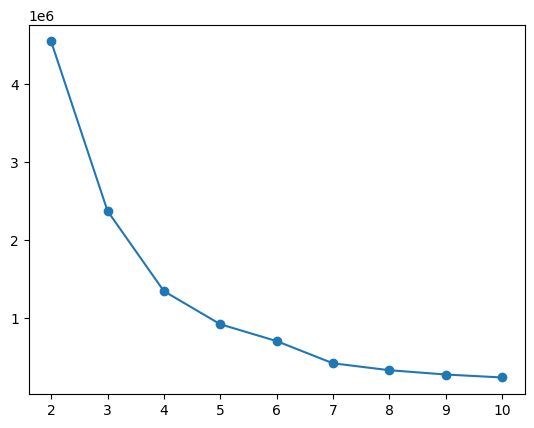

In [5]:
plt.plot(n_clusters, total_wcss_values)
plt.scatter(n_clusters, total_wcss_values)

### PCA + cluster analysis

In [6]:
from sklearn.decomposition import PCA

pca_df = PCA(n_components=.9).fit_transform(df)

pca_df.shape

(178, 1)

In [7]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

total_wcss_values = []

for n in n_clusters:

    kmeans = KMeans(n_clusters=n).fit(pca_df)
    b_kmeans = kmeans.predict(pca_df)

    total_wcss = 0

    for k in range(n):
        centroid = kmeans.cluster_centers_[k]
        cluster_k = pca_df[b_kmeans == k]

        # within cluster sum of squares
        total_wcss += np.sum(np.linalg.norm(cluster_k - centroid, axis=1)**2)
    
    total_wcss_values.append(total_wcss)

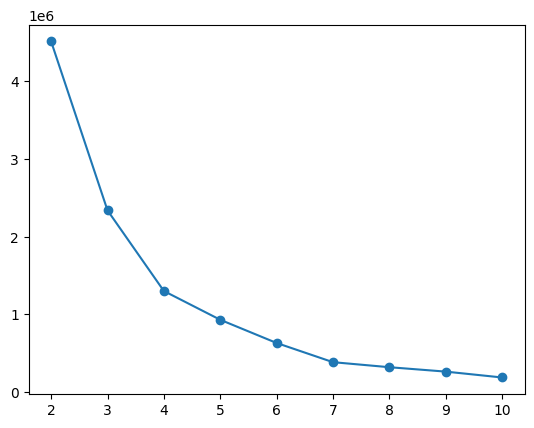

In [8]:
plt.plot(n_clusters, total_wcss_values)
plt.scatter(n_clusters, total_wcss_values)

### Analyze clusters

In [17]:
kmeans = KMeans(n_clusters=3).fit(df)
b_kmeans = kmeans.predict(df)

df['label'] = b_kmeans

df

Alcohol  Malic_Acid   Ash  Ash_Alcanity  Magnesium  Total_Phenols  \
0      14.23        1.71  2.43          15.6        127           2.80   
1      13.20        1.78  2.14          11.2        100           2.65   
2      13.16        2.36  2.67          18.6        101           2.80   
3      14.37        1.95  2.50          16.8        113           3.85   
4      13.24        2.59  2.87          21.0        118           2.80   
..       ...         ...   ...           ...        ...            ...   
173    13.71        5.65  2.45          20.5         95           1.68   
174    13.40        3.91  2.48          23.0        102           1.80   
175    13.27        4.28  2.26          20.0        120           1.59   
176    13.17        2.59  2.37          20.0        120           1.65   
177    14.13        4.10  2.74          24.5         96           2.05   

     Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  Color_Intensity   Hue  \
0          3.06                  0.28             2.29             5.64  1.04   
1          2.76                  0.26             1.28             4.38  1.05   
2          3.24                  0.30             2.81             5.68  1.03   
3          3.49                  0.24             2.18             7.80  0.86   
4          2.69                  0.39             1.82             4.32  1.04   
..          ...                   ...              ...              ...   ...   
173        0.61                  0.52             1.06             7.70  0.64   
174        0.75                  0.43             1.41             7.30  0.70   
175        0.69                  0.43             1.35            10.20  0.59   
176        0.68                  0.53             1.46             9.30  0.60   
177        0.76                  0.56             1.35             9.20  0.61   

     OD280  Proline  label  
0     3.92     1065      2  
1     3.40     1050      2  
2     3.17     1185      2  
3     3.45     1480      2  
4     2.93      735      0  
..     ...      ...    ...  
173   1.74      740      0  
174   1.56      750      0  
175   1.56      835      0  
176   1.62      840      0  
177   1.60      560      1  

[178 rows x 14 columns]

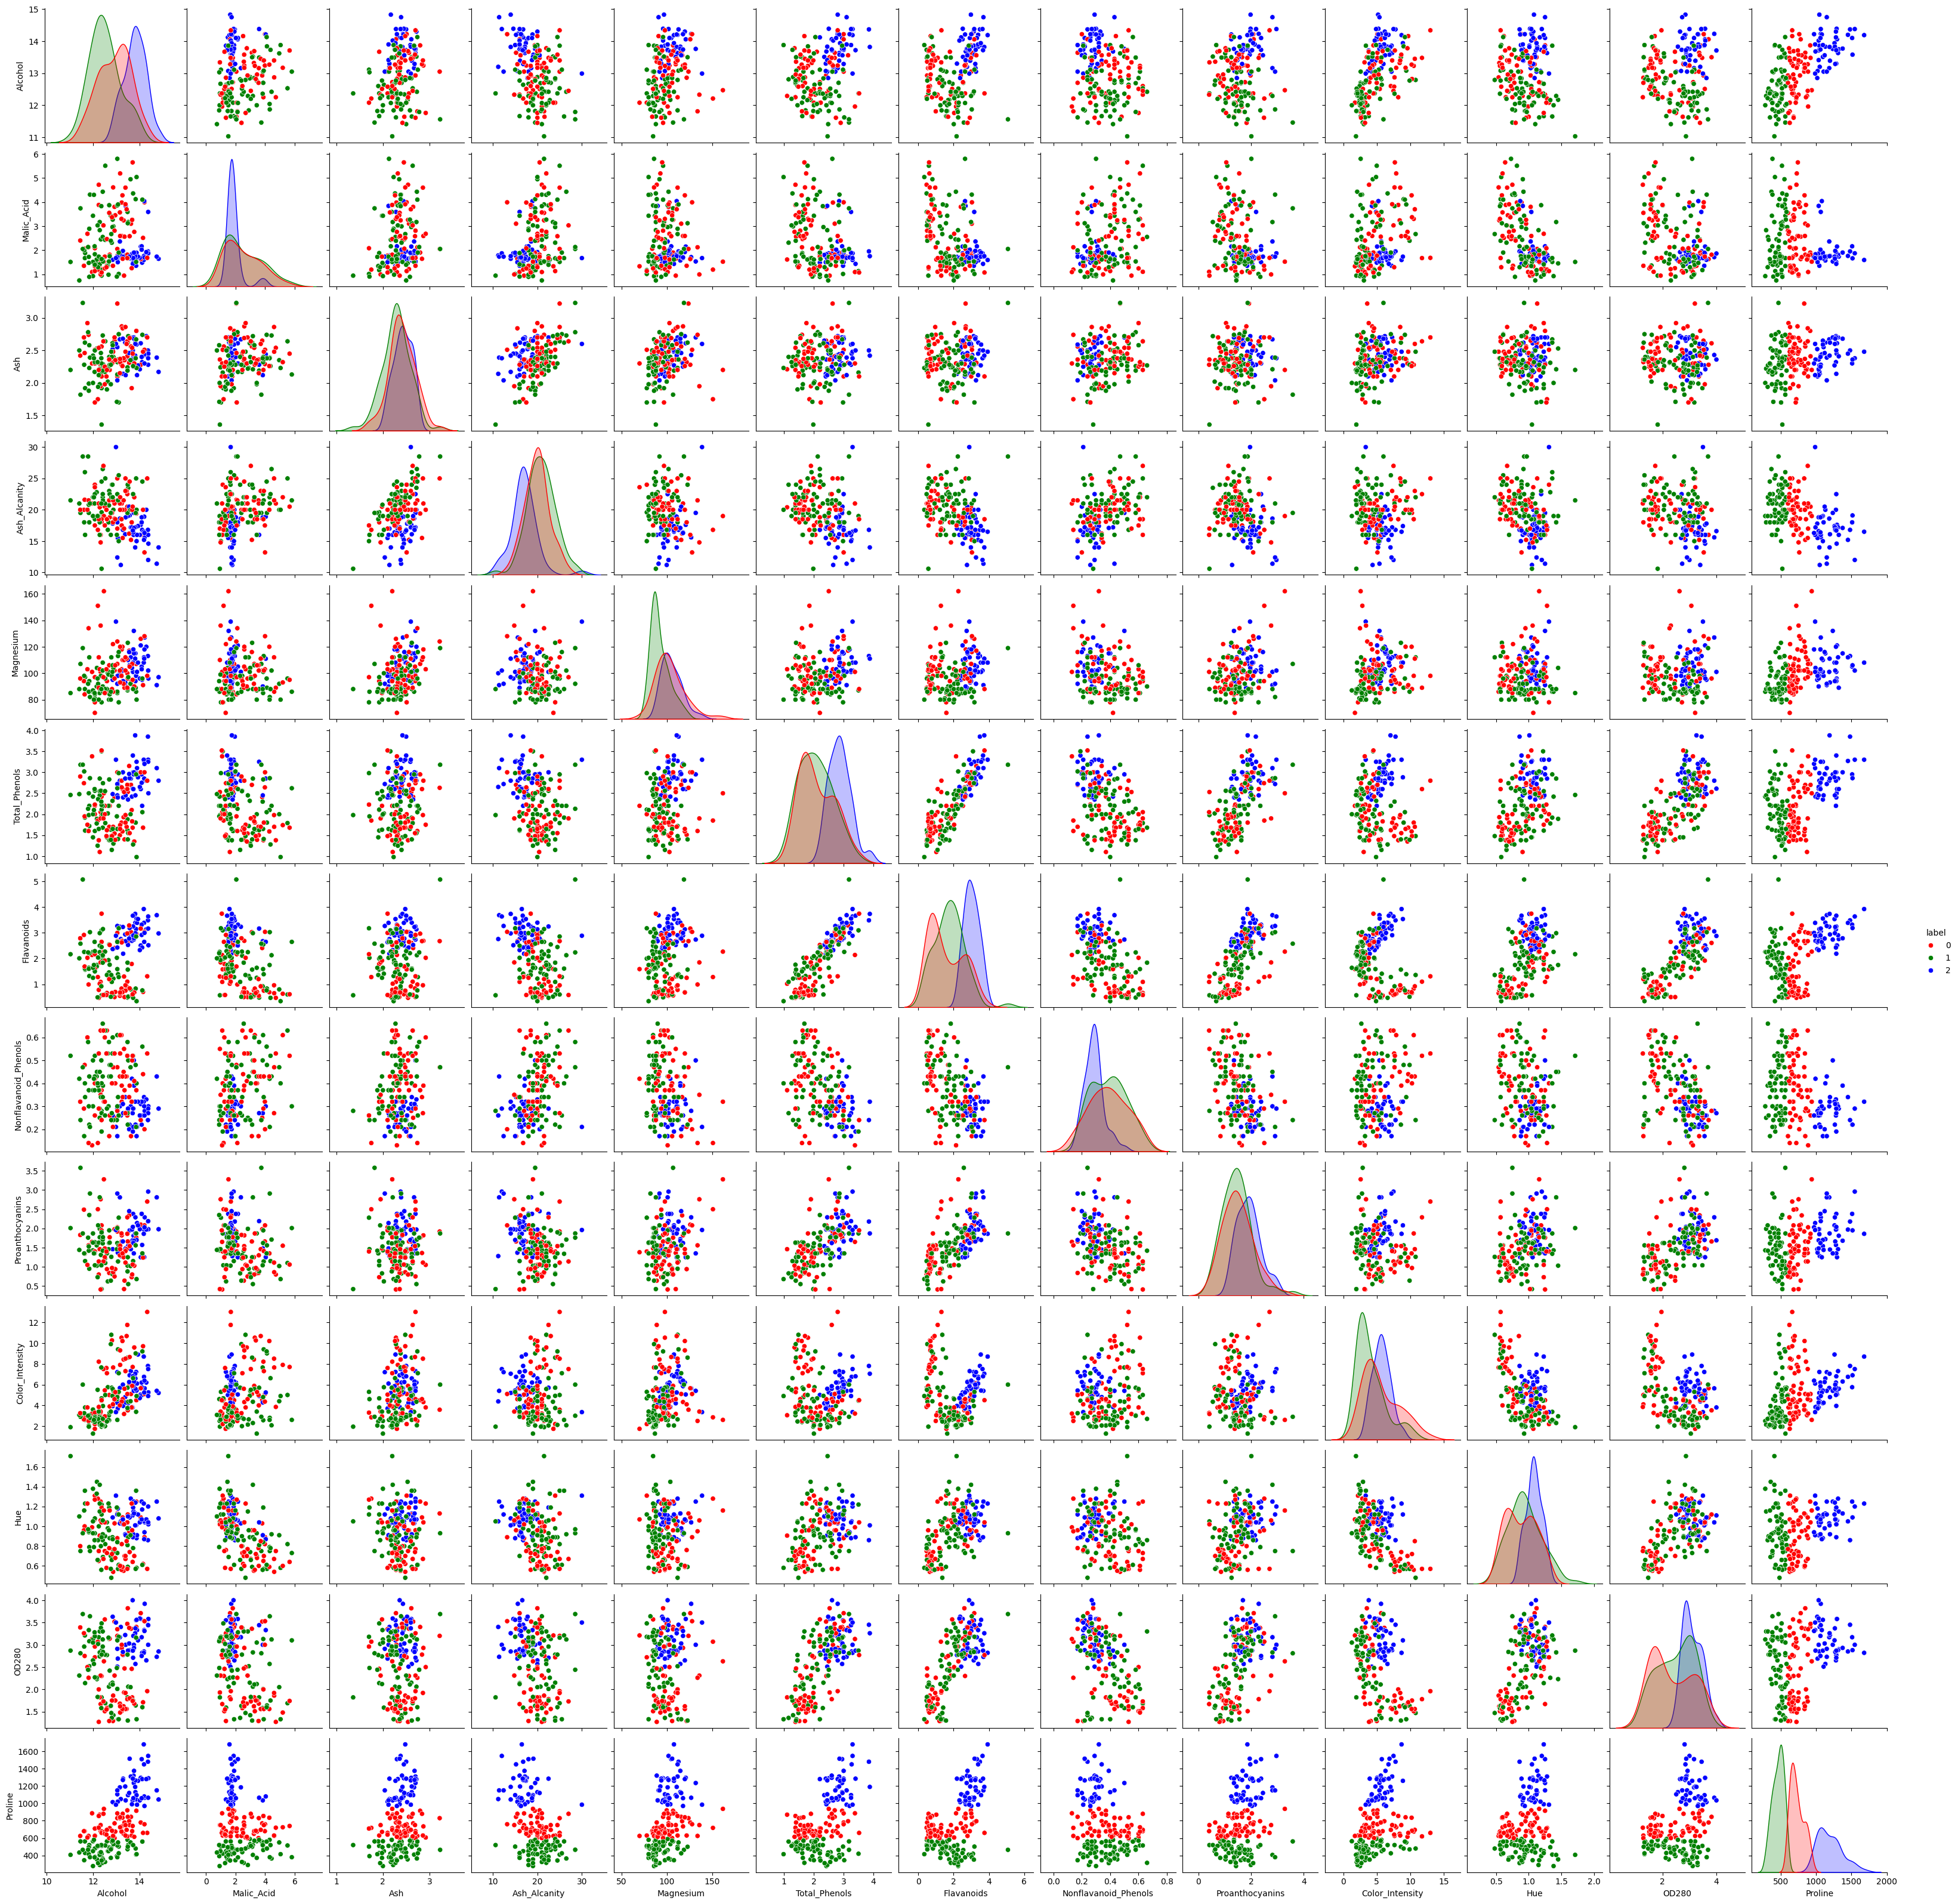

In [18]:
sns.pairplot(df, hue='label', palette=['r', 'g', 'b'])